# Cross section from radar HDF5-files

Finnish Meteorological Institute is providing radar images as GeoTiff and HDF5-files in S3 bucket. GeoTiff images contain processed data (typically from constant altitude) and HDF5-files raw radar volumes from single radars. The data is free and openly available with CC4BY license. Please consult https://en.ilmatieteenlaitos.fi/open-data for more information. 

This example illustrates few possible methods to access and process the HDF5-data with python. The example aims to help accessing and opening files provided by FMI. Related libraries and examples can be used to get more examples how to process the data. 

First, the environment. `gdal, dask, arm_pyart, xarray, h5py, h5netcdf, tqdm` are required for these examples wradlib https://docs.wradlib.org/en/stable/) and Py-ART (https://arm-doe.github.io/pyart/) being the main libraries. These notebooks are created with Amazon Sagemaker and environment are setup with following commands:
```
yum install -y --enablerepo="epel" netcdf4-python gdal gdal-python
conda create -c conda-forge --name fmiopendata ipykernel gdal dask arm_pyart xarray h5py h5netcdf tqdm
python -m ipykernel install --user --name fmiopendata --display-name "fmiopendata"
conda env export --name fmiopendata --file ~/fmiopendata.yml
```

Rasterio (https://github.com/mapbox/rasterio) and pyproj (https://pypi.org/project/pyproj/) are used in GeoTiff example.

In [ ]:
!conda install -y -c conda-forge gdal dask arm_pyart xarray h5py h5netcdf tqdm xarray wradlib rasterio[s3]

In [43]:
import xarray, h5py
import os, boto3
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from osgeo import gdal
import wradlib as wrl
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Unfortunately wradlib and Py-ART have only partial support for remote files so we need to download processed files to local tmp directory. Following function will do:

In [4]:
def download(bucket_name, key, dst_root='/tmp'):
    """ Download file from S3 
        
        bucket_name : str 
        key         : str
        dst_root    : str
                      Where files are located, must exists. 
                      Possible folder structure in key is followed under this directory.     
                      
        Returns
        -------
        str
           local filename
    """
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(bucket_name) 
    dst_filename = '{}/{}'.format(dst_root, key)
    
    for object in bucket.objects.filter(Prefix = key):
        dst = dst_root+'/'+object.key
        if not os.path.exists(os.path.dirname(dst)):
            os.makedirs(os.path.dirname(dst))
        s3.meta.client.download_file(bucket_name, key, dst_filename) 
    
    return dst_filename

Download some file of interest:

In [5]:
fname = download('fmi-radar-opendata-sandbox', 'h5/201112312355_radar.polar.fivan.h5')

Let's first open the file with wradlib and see what we have here. `print(vol)` tells us that the file contain two sweeps with angles 1.5 and 3 degrees. With a command `print(vol[0].data` we can see geospatial and temporal dimensions of the first sweep. 

More detailed documentation can be found here: https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_radial_odim.html

In [6]:
vol = wrl.io.xarray.open_odim(fname, loader='h5py', chunks={})
print('Whole volume: \n{}\n'.format(vol))
print('First sweep as xarray: \n{}'.format(vol[0].data))

Collecting: 100%|██████████| 1/1 [00:00<00:00, 26.15 Timesteps/s]

Whole volume: 
<wradlib.XRadVolume>
Dimension(s): (sweep: 2)
Elevation(s): (1.5, 3.0)

First sweep as xarray: 
<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 500, time: 1)
Coordinates:
    altitude    float64 ...
    rtime       (azimuth) datetime64[ns] ...
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    elevation   (azimuth) float32 ...
  * range       (range) float32 250.0 750.0 1250.0 ... 249250.0 249750.0
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) datetime64[ns] 2011-12-31T23:55:58
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 500), meta=np.ndarray>


We can also plot the sweeps. X and Y axis are just range from the radar.

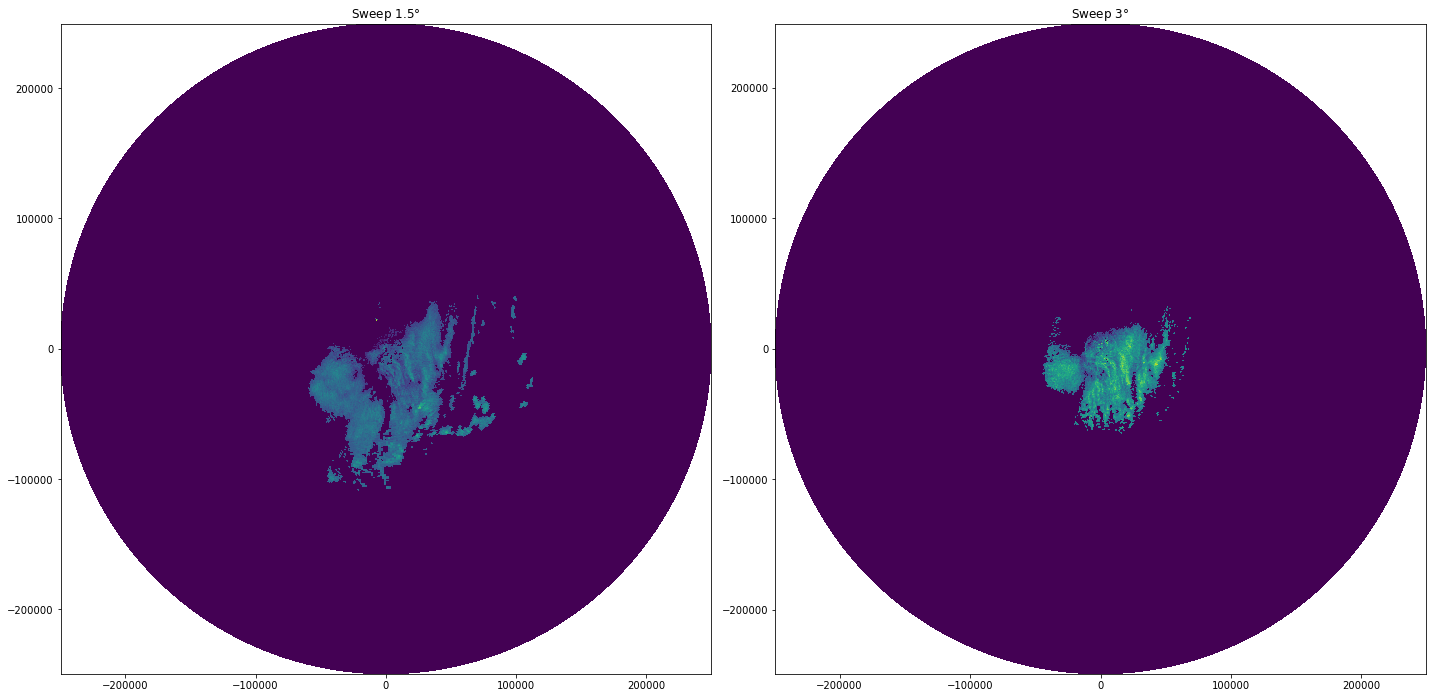

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
vol[0].data.pipe(wrl.georef.georeference_dataset).DBZH[0].wradlib.plot(ax=axes[0])
vol[1].data.pipe(wrl.georef.georeference_dataset).DBZH[0].wradlib.plot(ax=axes[1])

axes[0].set_title('Sweep 1.5$\degree$')
axes[1].set_title('Sweep 3$\degree$')
plt.tight_layout()

We can plot PPI in WGS84 following:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8232472208>,
 <matplotlib.collections.QuadMesh at 0x7f823251f518>)

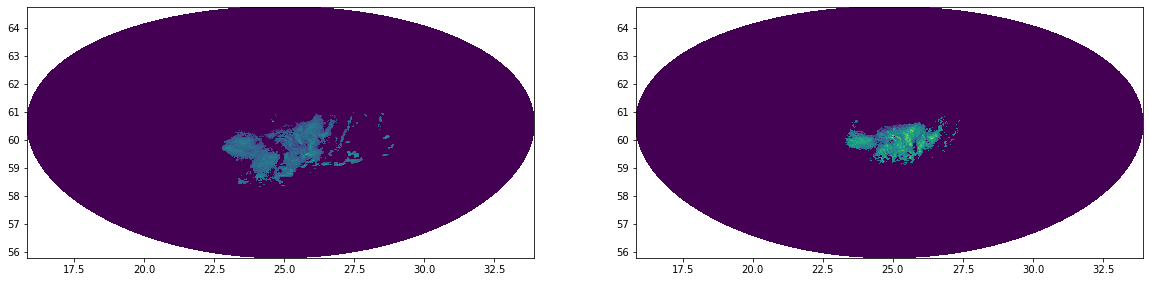

In [38]:
r = np.arange(vol[0].data.DBZH[0].shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
r *= 1000

epsg = wrl.georef.proj4_to_osr('+proj=longlat +datum=WGS84 +no_defs')

fig, axes = plt.subplots(1, 2, figsize=(20,10))
wrl.vis.plot_ppi(vol[0].data.DBZH[0], proj=epsg, site=(vol[0].data.longitude.data, vol[0].data.latitude.data, vol[0].data.altitude.data), r=r, ax=axes[0])
wrl.vis.plot_ppi(vol[1].data.DBZH[0], proj=epsg, site=(vol[0].data.longitude.data, vol[1].data.latitude.data, vol[1].data.altitude.data), r=r, ax=axes[1])

Please consult wradlib documentation (https://docs.wradlib.org/en/stable/index.html) for more information. 

Another nice library for handling the data is Py-ART (https://arm-doe.github.io/pyart/index.html). First reading the data:

In [45]:
radar = pyart.aux_io.read_odim_h5(fname, file_field_names=True)

PPI can be plotted following: 

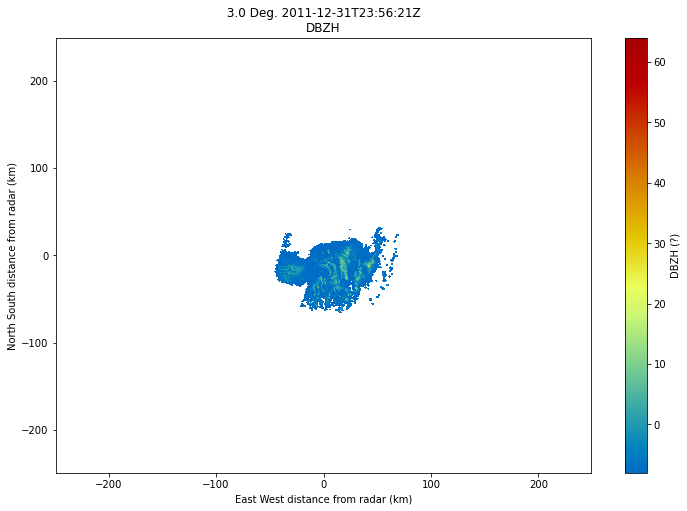

In [50]:
display = pyart.graph.RadarDisplay(radar)
my_figure = plt.figure(figsize=[12, 8])
display.plot_ppi('DBZH', 1, vmin=-8, vmax=64)

Last, we can plot cross sections along some latitude and longitude. Following example is adapted from: 
https://nbviewer.jupyter.org/github/ARM-DOE/notebooks/blob/master/ASR_PI_2014/Plotting%20PPIs%2C%20CFADs%2C%20and%20mapping.ipynb. 

First we create a grid in WGS84 from the data: 

In [109]:
grids = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(100, 360, 500), # 100 vertical levels + original data size 
        grid_limits= ((0, 11000), (-100.00*1000.0, 100.*1000.0), (-100.0*1000.0, 100.*1000.0)), # 100 km from radar center
        fields=['DBZH'],
        refl_field='DBZH',
        max_refl=100.)

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


And then we can plot the cross sections using Py-ART:

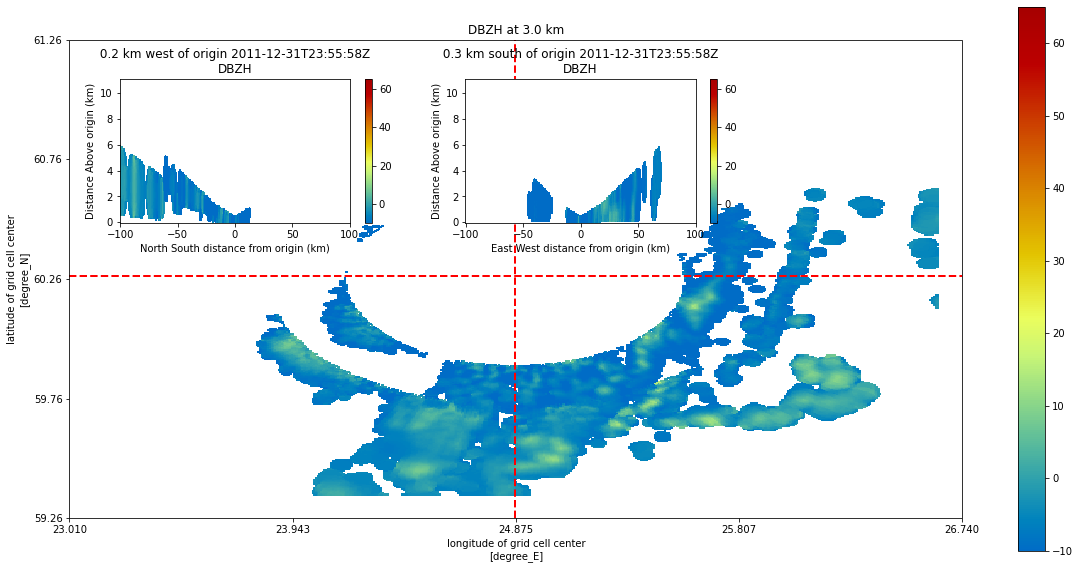

In [171]:
# panel sizes
x_cut_panel_axes = [0.16, 0.58, .2, .2]
y_cut_panel_axes = [0.4, 0.58, .2, .2]

# parameters
level = 30 # 3 km above ground
# We take radar centeer from wradlib object
lat = lat=vol[0].data.latitude.data
lon = lon=vol[0].data.longitude.data

fig = plt.figure(figsize=[20, 10])

grid_display = pyart.graph.GridMapDisplay(grids)

grid_display.plot_grid('DBZH', level=level, title='DBZH at {} km'.format(level/10), ax=ax1)
grid_display.plot_crosshairs(lon=lon, lat=lat) 

ax2 = fig.add_axes(x_cut_panel_axes)
grid_display.plot_longitude_slice('DBZH', lon=lon, lat=lat)

ax3 = fig.add_axes(y_cut_panel_axes)
grid_display.plot_latitude_slice('DBZH', lon=lon, lat=lat)


Hopefully these examples helps to handle the data. Following resources provide more examples:
* https://github.com/ANL-DIGR/notebooks
* https://github.com/openradar/open_source_radar_short_course
* https://unidata.github.io/MetPy/latest/index.html